In [61]:
import pandas as pd
import numpy as np 
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
traffic_data = pd.read_csv("traffic_data.csv")

In [62]:
traffic_data.head()

,DateTime,Junction,Vehicles,Vehicles_normalized,temperature,wind_speed,humidity,precipitation,Name,City,Venue
0,01-11-2015 00:00,1,15,0.078212,8,9.312206,39.0,4.241390,Imagine Dragons: LOOM WORLD TOUR,Hollywood,Hollywood Bowl
1,01-11-2015 01:00,1,13,0.067039,28,7.894646,78.0,2.408451,Imagine Dragons: LOOM WORLD TOUR,Hollywood,Hollywood Bowl
2,01-11-2015 02:00,1,10,0.050279,-3,0.410783,76.0,4.121092,The Spinners,Pasadena,The Rose
3,01-11-2015 03:00,1,7,0.033520,28,3.957074,71.0,4.915204,The Spinners,Pasadena,The Rose
4,01-11-2015 04:00,1,9,0.044693,39,8.284830,36.0,3.615275,Fool in Love,Inglewood,Hollywood Park Grounds


In [63]:
traffic_data.isnull().sum()

DateTime               0
Junction               0
Vehicles               0
Vehicles_normalized    0
temperature            0
wind_speed             0
humidity               0
precipitation          0
Name                   0
City                   0
Venue                  0
dtype: int64

In [64]:
traffic_data.drop_duplicates(inplace=True)

In [65]:
traffic_data.isna()

,DateTime,Junction,Vehicles,Vehicles_normalized,temperature,wind_speed,humidity,precipitation,Name,City,Venue
0,False,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...
48115,False,False,False,False,False,False,False,False,False,False,False
48116,False,False,False,False,False,False,False,False,False,False,False
48117,False,False,False,False,False,False,False,False,False,False,False
48118,False,False,False,False,False,False,False,False,False,False,False


In [66]:
traffic_data['DateTime'] = pd.to_datetime(traffic_data['DateTime'], format='%d-%m-%Y %H:%M')

In [67]:
# Convert DateTime column to datetime format and extract hour
traffic_data['DateTime'] = pd.to_datetime(traffic_data['DateTime'])
traffic_data['Hour'] = traffic_data['DateTime'].dt.hour

GBT MSE: 409.6255456222417


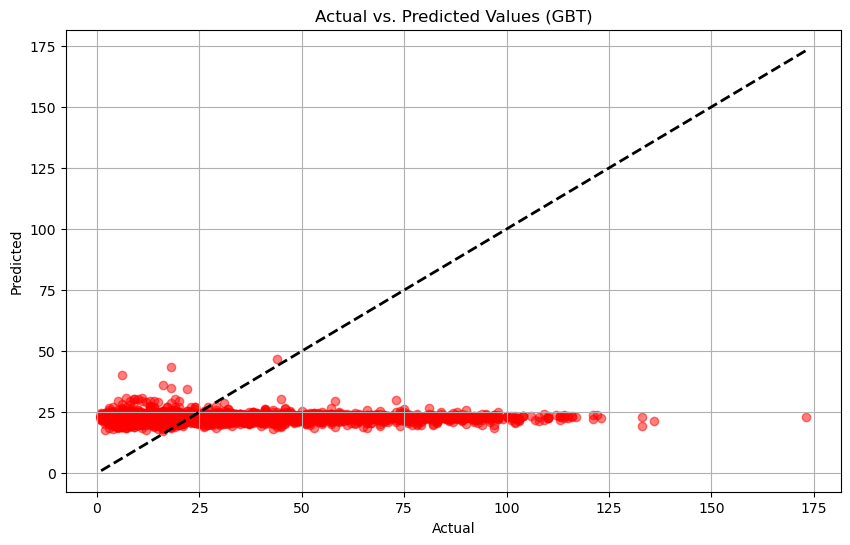

Feature Importances:
temperature      0.085237
precipitation    0.274209
humidity         0.332550
wind_speed       0.308004
dtype: float64


In [68]:
from sklearn.ensemble import GradientBoostingRegressor
# Assuming your data is stored in a DataFrame called 'merged_data'
features = ['temperature', 'precipitation', 'humidity', 'wind_speed']
target = 'Vehicles'

# Split data into features (X) and target variable (y)
X = traffic_data[features]
y = traffic_data[target]

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize Gradient Boosting model
gbt_model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)

# Train Gradient Boosting model
gbt_model.fit(X_train, y_train)

# Make predictions
y_pred = gbt_model.predict(X_test)

# Evaluate Gradient Boosting model
mse_gbt = mean_squared_error(y_test, y_pred)
print(f"GBT MSE: {mse_gbt}")

# Plotting actual vs. predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, color='red', alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs. Predicted Values (GBT)')
plt.grid(True)
plt.show()

# Optionally, inspect feature importances
feature_importances = pd.Series(gbt_model.feature_importances_, index=features)
print("Feature Importances:")
print(feature_importances)


Best params: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100} with MSE: 31.852027161724912
RMSE: 5.2970237425331295


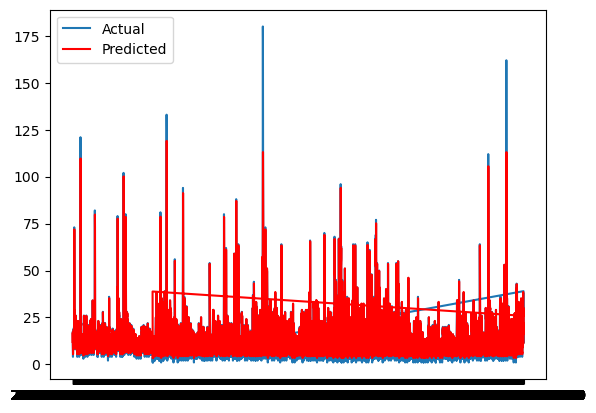

In [69]:
#Gradient boosting trees(XGboost) with Gridsearch
import xgboost as xgb
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Load your time series data
data = pd.read_csv('traffic_data.csv', index_col='DateTime', parse_dates=True)
data['lag_1'] = data['Vehicles'].shift(1) 
data.dropna(inplace=True)

# Create features and labels
X = data[['lag_1']]
y = data['Vehicles']

# Define parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.3]
}

# TimeSeriesSplit for time-based cross-validation
tscv = TimeSeriesSplit(n_splits=5)

# GridSearchCV with XGBoost
model = xgb.XGBRegressor(objective='reg:squarederror')
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=tscv)
grid_search.fit(X, y)

print(f'Best params: {grid_search.best_params_} with MSE: {abs(grid_search.best_score_)}')

# Split data into training and validation sets
train_size = int(len(X) * 0.8)
X_train, X_val = X[:train_size], X[train_size:]
y_train, y_val = y[:train_size], y[train_size:]

# Train the best model
best_model = grid_search.best_estimator_
best_model.fit(X_train, y_train)

# Make predictions on validation data
val_predictions = best_model.predict(X_val)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_val, val_predictions))
print(f'RMSE: {rmse}')

# Plot results
plt.plot(y_val.index, y_val, label='Actual')
plt.plot(y_val.index, val_predictions, label='Predicted', color='red')
plt.legend()
plt.show()


In [70]:
#Evaluation Metrics
import xgboost as xgb
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Load your time series data
data = pd.read_csv('traffic_data.csv', index_col='DateTime', parse_dates=True)
data['lag_1'] = data['Vehicles'].shift(1) 
data.dropna(inplace=True)

# Create features and labels
X = data[['lag_1']]
y = data['Vehicles']

# Defining parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.3]
}

# TimeSeriesSplit for time-based cross-validation
tscv = TimeSeriesSplit(n_splits=5)

# GridSearchCV with XGBoost
model = xgb.XGBRegressor(objective='reg:squarederror')
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=tscv)
grid_search.fit(X, y)

print(f'Best params: {grid_search.best_params_} with MSE: {abs(grid_search.best_score_)}')

# Split data into training and validation sets
train_size = int(len(X) * 0.8)
X_train, X_val = X[:train_size], X[train_size:]
y_train, y_val = y[:train_size], y[train_size:]

# Train the best model
best_model = grid_search.best_estimator_
best_model.fit(X_train, y_train)

# Make predictions on validation data
val_predictions = best_model.predict(X_val)

# Evaluate predictions
mae = mean_absolute_error(y_val, val_predictions)
rmse = mean_squared_error(y_val, val_predictions, squared=False)
r2 = r2_score(y_val, val_predictions)

print(f'MAE: {mae}')
print(f'RMSE: {rmse}')
print(f'R-squared: {r2}')



Best params: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100} with MSE: 31.852027161724912
MAE: 3.068742876784165
RMSE: 5.2970237425331295
R-squared: 0.7175653793126613


Best params: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100} with MSE: 31.852027161724912
MAE: 3.068742876784165
RMSE: 5.2970237425331295
R-squared: 0.7175653793126613


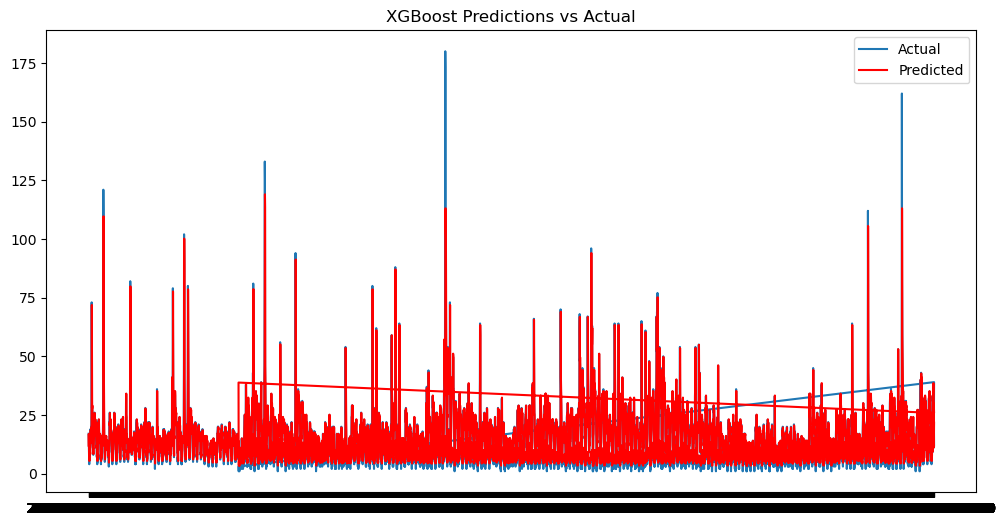

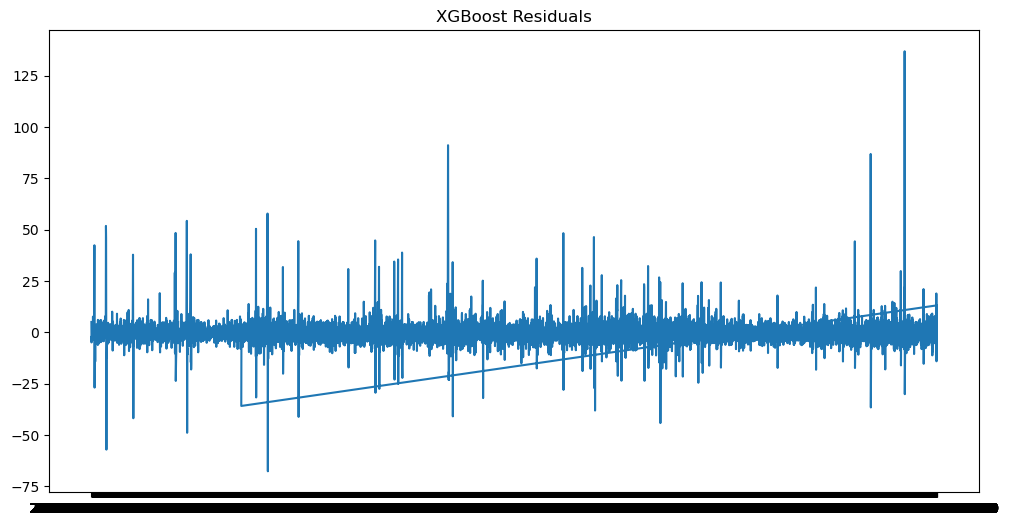

C:\Users\rohit\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


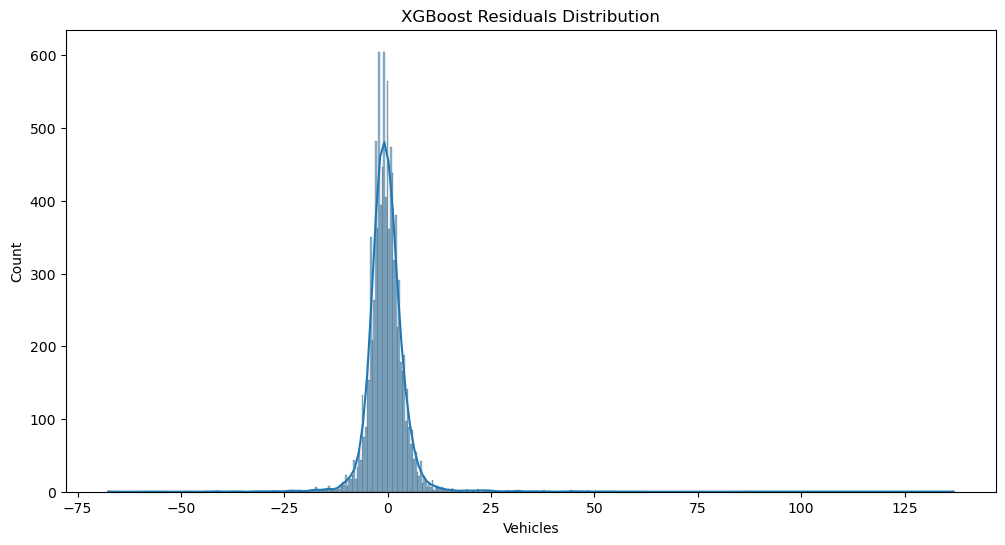

In [71]:
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

# Load your time series data
data = pd.read_csv('traffic_data.csv', index_col='DateTime', parse_dates=True)
data['lag_1'] = data['Vehicles'].shift(1)  # Replace 'value' with your column name
data.dropna(inplace=True)

# Create features and labels
X = data[['lag_1']]
y = data['Vehicles']

# Define parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.3]
}

# TimeSeriesSplit for time-based cross-validation
tscv = TimeSeriesSplit(n_splits=5)

# GridSearchCV with XGBoost
model = xgb.XGBRegressor(objective='reg:squarederror')
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=tscv)
grid_search.fit(X, y)

print(f'Best params: {grid_search.best_params_} with MSE: {abs(grid_search.best_score_)}')

# Split data into training and validation sets
train_size = int(len(X) * 0.8)
X_train, X_val = X[:train_size], X[train_size:]
y_train, y_val = y[:train_size], y[train_size:]

# Train the best model
best_model = grid_search.best_estimator_
best_model.fit(X_train, y_train)

# Make predictions on validation data
val_predictions = best_model.predict(X_val)

# Evaluate predictions
mae = mean_absolute_error(y_val, val_predictions)
rmse = mean_squared_error(y_val, val_predictions, squared=False)
r2 = r2_score(y_val, val_predictions)

print(f'MAE: {mae}')
print(f'RMSE: {rmse}')
print(f'R-squared: {r2}')

# Plot results
plt.figure(figsize=(12, 6))
plt.plot(y_val.index, y_val, label='Actual')
plt.plot(y_val.index, val_predictions, label='Predicted', color='red')
plt.title('XGBoost Predictions vs Actual')
plt.legend()
plt.show()

# Residual plot
residuals = y_val - val_predictions
plt.figure(figsize=(12, 6))
plt.plot(y_val.index, residuals)
plt.title('XGBoost Residuals')
plt.show()

# Error distribution plot
plt.figure(figsize=(12, 6))
sns.histplot(residuals, kde=True)
plt.title('XGBoost Residuals Distribution')
plt.show()


In [72]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import TimeSeriesSplit

# Load your time series data
data = pd.read_csv('traffic_data.csv', index_col='DateTime', parse_dates=True)
data['lag_1'] = data['Vehicles'].shift(1) 

# Create features and labels
X = data[['lag_1']]
y = data['Vehicles']

# Time-based cross-validation
tscv = TimeSeriesSplit(n_splits=5)
mae_scores = []
rmse_scores = []
r2_scores = []

for train_index, val_index in tscv.split(X):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]
    
    model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, max_depth=3, learning_rate=0.1)
    model.fit(X_train, y_train)
    val_predictions = model.predict(X_val)
    
    mae_scores.append(mean_absolute_error(y_val, val_predictions))
    rmse_scores.append(mean_squared_error(y_val, val_predictions, squared=False))
    r2_scores.append(r2_score(y_val, val_predictions))

print(f'MAE: {np.mean(mae_scores)}')
print(f'RMSE: {np.mean(rmse_scores)}')
print(f'R-squared: {np.mean(r2_scores)}')


MAE: 3.498276827703985
RMSE: 5.218629243361919
R-squared: 0.7469539766165052


   Fold       MAE      RMSE  R-squared
0     1  6.330052  8.900560   0.900992
1     2  2.179052  2.753220   0.575759
2     3  2.694434  3.548343   0.868049
3     4  3.333327  5.909580   0.655782
4     5  2.966636  4.994604   0.734159
MAE Mean: 3.5007001241702276, MAE Std: 1.463918539920843
RMSE Mean: 5.221261563440981, RMSE Std: 2.142534678332828
R-squared Mean: 0.7469481622278348, R-squared Std: 0.12343076203303076


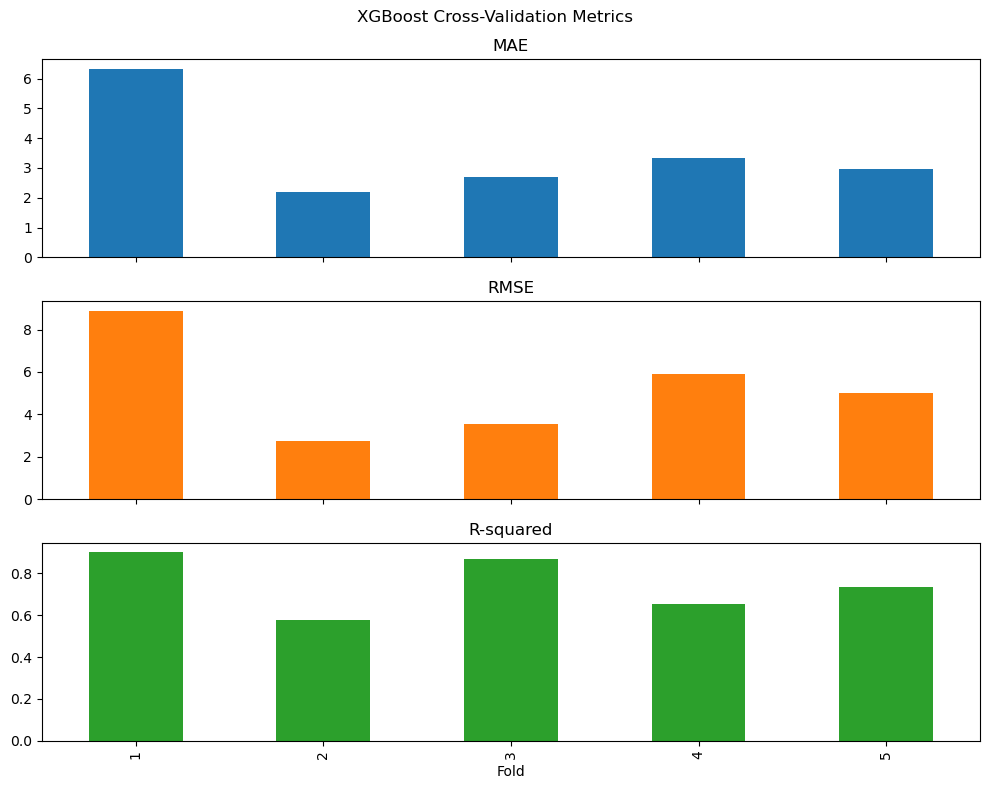

In [73]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt

# Load your time series data
data = pd.read_csv('traffic_data.csv', index_col='DateTime', parse_dates=True)
data['lag_1'] = data['Vehicles'].shift(1) 
data.dropna(inplace=True)

# Create features and labels
X = data[['lag_1']]
y = data['Vehicles']

# Time-based cross-validation
tscv = TimeSeriesSplit(n_splits=5)
mae_scores = []
rmse_scores = []
r2_scores = []

for train_index, val_index in tscv.split(X):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]
    
    model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, max_depth=3, learning_rate=0.1)
    model.fit(X_train, y_train)
    val_predictions = model.predict(X_val)
    
    mae_scores.append(mean_absolute_error(y_val, val_predictions))
    rmse_scores.append(mean_squared_error(y_val, val_predictions, squared=False))
    r2_scores.append(r2_score(y_val, val_predictions))

# Compile results
results = pd.DataFrame({
    'Fold': range(1, len(mae_scores) + 1),
    'MAE': mae_scores,
    'RMSE': rmse_scores,
    'R-squared': r2_scores
})

print(results)
print(f'MAE Mean: {np.mean(mae_scores)}, MAE Std: {np.std(mae_scores)}')
print(f'RMSE Mean: {np.mean(rmse_scores)}, RMSE Std: {np.std(rmse_scores)}')
print(f'R-squared Mean: {np.mean(r2_scores)}, R-squared Std: {np.std(r2_scores)}')

# Plot metrics
results.set_index('Fold').plot(kind='bar', subplots=True, layout=(3, 1), figsize=(10, 8), legend=False, title='XGBoost Cross-Validation Metrics')
plt.tight_layout()
plt.show()


In [74]:
import pandas as pd
# Convert timestamp to datetime if it's not already
traffic_data['DateTime'] = pd.to_datetime(traffic_data['DateTime'])

# Extract hour and day of week
traffic_data['hour'] = traffic_data['DateTime'].dt.hour
traffic_data['day_of_week'] = traffic_data['DateTime'].dt.dayofweek

# Compute average vehicle count per hour
avg_vehicle_count_per_hour = traffic_data.groupby('hour')['Vehicles'].mean()

# Assume a free-flow speed (e.g., speed limit)
free_flow_speed = 60

# Compute metrics across different days and hours
avg_vehicle_count_per_day_hour = traffic_data.groupby(['day_of_week', 'hour'])['Vehicles'].mean()
# Output the results
print("Average Vehicle Count per Hour:")
print(avg_vehicle_count_per_hour)


Average Vehicle Count per Hour:
hour
0     23.540648
1     19.654863
2     17.102743
3     14.847382
4     12.973067
5     12.173566
6     12.980050
7     14.703242
8     16.402993
9     19.379551
10    24.229925
11    27.495262
12    28.403990
13    25.588529
14    27.702743
15    27.650374
16    26.674314
17    26.648379
18    28.095262
19    29.854863
20    29.824938
21    28.202993
22    27.226933
23    25.635411
Name: Vehicles, dtype: float64


In [75]:

# Convert timestamp to datetime if it's not already
traffic_data['DateTime'] = pd.to_datetime(traffic_data['DateTime'])

# Extract hour and day of week
traffic_data['hour'] = traffic_data['DateTime'].dt.hour
traffic_data['day_of_week'] = traffic_data['DateTime'].dt.dayofweek

# Compute average vehicle count per hour
avg_vehicle_count_per_hour = traffic_data.groupby('hour')['Vehicles'].mean()
# Calculate moving averages (window size of 3 for smoothing)
window_size = 3
moving_avg_vehicle_count = avg_vehicle_count_per_hour.rolling(window=window_size, center=True).mean()

# Calculate standard deviation to measure consistency
std_dev_vehicle_count = avg_vehicle_count_per_hour.rolling(window=window_size, center=True).std()

# Identify peak hours based on moving average and standard deviation
threshold_vehicle_count = moving_avg_vehicle_count.mean() + moving_avg_vehicle_count.std()
peak_hours_vehicle_count = avg_vehicle_count_per_hour[avg_vehicle_count_per_hour > threshold_vehicle_count]

# Output the results
print("Peak Hours based on Vehicle Count:")
print(peak_hours_vehicle_count)


Peak Hours based on Vehicle Count:
hour
19    29.854863
20    29.824938
Name: Vehicles, dtype: float64


In [76]:

# Convert timestamp to datetime if it's not already
traffic_data['DateTime'] = pd.to_datetime(traffic_data['DateTime'])

# Extract hour, day of the week, and month
traffic_data['hour'] = traffic_data['DateTime'].dt.hour
traffic_data['day_of_week'] = traffic_data['DateTime'].dt.dayofweek
traffic_data['month'] = traffic_data['DateTime'].dt.month

# Define function to identify peak hours
def identify_peak_hours(data, group_by_cols, value_col, window_size=3):
    # Compute averages
    avg_value = data.groupby(group_by_cols)[value_col].mean()
    # Calculate moving averages
    moving_avg = avg_value.rolling(window=window_size, center=True).mean()
    # Calculate standard deviation
    std_dev = avg_value.rolling(window=window_size, center=True).std()
    # Calculate threshold
    threshold = moving_avg.mean() + moving_avg.std()
    # Identify peak hours
    peak_hours = avg_value[avg_value > threshold]
    return peak_hours

# Day of the Week Analysis
peak_hours_vehicle_count_weekday = identify_peak_hours(traffic_data, ['day_of_week', 'hour'], 'Vehicles')
# Monthly Analysis
peak_hours_vehicle_count_monthly = identify_peak_hours(traffic_data, ['month', 'hour'], 'Vehicles')

# Seasonal Analysis
traffic_data['season'] = traffic_data['month'] % 12 // 3 + 1  # Winter: 1, Spring: 2, Summer: 3, Fall: 4
peak_hours_vehicle_count_seasonal = identify_peak_hours(traffic_data, ['season', 'hour'], 'Vehicles')

# Output the results
print("Peak Hours based on Vehicle Count (Weekdays):")
print(peak_hours_vehicle_count_weekday)

print("\nPeak Hours based on Vehicle Count (Monthly):")
print(peak_hours_vehicle_count_monthly)

print("\nPeak Hours based on Vehicle Count (Seasonal):")
print(peak_hours_vehicle_count_seasonal)


Peak Hours based on Vehicle Count (Weekdays):
day_of_week  hour
0            11      32.076655
             12      33.177700
             14      32.278746
             15      32.278746
             16      30.721254
             17      30.501742
             18      31.470383
             19      32.996516
             20      31.864111
             21      30.400697
1            11      30.428571
             12      31.982578
             14      31.742160
             15      31.926829
             16      30.783972
             17      30.766551
             18      31.958188
             19      33.048780
             20      32.059233
             21      30.362369
2            11      30.836237
             12      31.585366
             14      31.473868
             15      31.463415
             16      29.759582
             17      30.017422
             18      31.101045
             19      32.581882
             20      32.240418
             21      30.724739
      

In [80]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

# Convert timestamp to datetime if it's not already
traffic_data['timestamp'] = pd.to_datetime(traffic_data['timestamp'])

# Extract hour and day of the week
traffic_data['hour'] = traffic_data['timestamp'].dt.hour
traffic_data['day_of_week'] = traffic_data['timestamp'].dt.dayofweek

# Compute average vehicle count and speed reduction per hour
traffic_data['speed_reduction'] = 60 - traffic_data['speed']

# Ensure all numeric columns are converted to the correct data type
numeric_columns = ['vehicle_count', 'speed', 'temperature', 'precipitation', 'special_event', 'speed_reduction']
traffic_data[numeric_columns] = traffic_data[numeric_columns].apply(pd.to_numeric)

# Aggregate data to hourly level
traffic_data['hourly_timestamp'] = traffic_data['timestamp'].dt.floor('H')
hourly_data = traffic_data.groupby('hourly_timestamp').mean().reset_index()

# Correlation Analysis
correlation_matrix = hourly_data[['vehicle_count', 'speed_reduction', 'temperature', 'precipitation', 'special_event']].corr()
print("Correlation Matrix:")
print(correlation_matrix)

# Regression Analysis
X = hourly_data[['temperature', 'precipitation', 'special_event']]
y_vehicle_count = hourly_data['vehicle_count']
y_speed_reduction = hourly_data['speed_reduction']

# Add a constant term for the regression model
X = sm.add_constant(X)

# Vehicle Count Regression Model
model_vehicle_count = sm.OLS(y_vehicle_count, X).fit()
print("\nVehicle Count Regression Model Summary:")
print(model_vehicle_count.summary())

# Speed Reduction Regression Model
model_speed_reduction = sm.OLS(y_speed_reduction, X).fit()
print("\nSpeed Reduction Regression Model Summary:")
print(model_speed_reduction.summary())


Correlation Matrix:
                 vehicle_count  speed_reduction  temperature  precipitation  \
vehicle_count         1.000000        -0.139357     0.064340       0.057032   
speed_reduction      -0.139357         1.000000     0.000262      -0.137082   
temperature           0.064340         0.000262     1.000000      -0.046766   
precipitation         0.057032        -0.137082    -0.046766       1.000000   
special_event        -0.097612         0.068873     0.063336      -0.135301   

                 special_event  
vehicle_count        -0.097612  
speed_reduction       0.068873  
temperature           0.063336  
precipitation        -0.135301  
special_event         1.000000  

Vehicle Count Regression Model Summary:
                            OLS Regression Results                            
Dep. Variable:          vehicle_count   R-squared:                       0.017
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least